In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import transforms, datasets

import matplotlib.pyplot as plt

import sys
sys.path.append("../")

from simulationmodel import *
from sampling_utils import *


# Loading MNIST data
train = datasets.FashionMNIST("../", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
trainset = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

test = datasets.FashionMNIST("../", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))
testset = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True)


SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def compute_accuracy(model):
    model.eval()
    accurate = 0
    total = 0
    with torch.no_grad():
        for X, y in testset:
            pred_dist = model(X.view(-1, 28*28))
            pred_y = torch.argmax(pred_dist, dim=-1)
            accurate += torch.sum(pred_y==y).numpy()
            total += y.shape[0]
    
    return round(accurate/total*100, 1)

def truncate_quantile(model, q_):
    model.eval()
    for layer in model.hidden_layers:
        q = np.quantile(np.sqrt(layer.get_variances().detach().numpy()), q_)
        layer.trunc_eps = q
        
    q = np.quantile(np.sqrt(model.output_layer.get_variances().detach().numpy()), q_)
    model.output_layer.trunc_eps = q
    
def transform_normal(model):
    model.eval()
    for layer in model.hidden_layers:
        if True:#layer.var_dist.is_static:
            w = np.sum(layer.weight.detach().numpy()**2, axis=0).reshape(1,-1)
            layer.transformed_variances.data = layer.transformed_variances.data * w
            w[w==0] = 1
            layer.weight.data = layer.weight.data / np.sqrt(w)
    
    layer = model.output_layer
    if True:#layer.var_dist.is_static:
        w = np.sum(layer.weight.detach().numpy()**2, axis=0).reshape(1,-1)
        layer.transformed_variances.data = layer.transformed_variances.data * w
        w[w==0] = 1
        layer.weight.data = layer.weight.data / np.sqrt(w)  
    

## Accuracy of the models

In [3]:
# Load trained models
p_list = [500, 1000, 2000]
p_list = [2000]
folder = "../trained_models/fashion_results_h_3_corrected"
n_runs = 5

n_acc = []
tn_acc = []
h_acc = []
g_acc = []
gm_acc = []
gl_acc = []
p_list_ = []

for r in range(1, n_runs+1):
    for p in tqdm(p_list):
        p_list_.append(p)
        
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        n_acc.append(compute_accuracy(normal_net))

        transform_normal(normal_net)
        tn_acc.append(compute_accuracy(normal_net))

        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        h_acc.append(compute_accuracy(horseshoe_net))

        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        g_acc.append(compute_accuracy(gbfry_heavy_net))
        
        gbfry_mid_net = torch.load('{}/gbfry_mid_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        gm_acc.append(compute_accuracy(gbfry_mid_net))
        
        gbfry_light_net = torch.load('{}/gbfry_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        gl_acc.append(compute_accuracy(gbfry_light_net))
    
results = pd.DataFrame.from_dict({
    "p": p_list_,
    "transformed_normal": tn_acc,
    "normal": n_acc,
    "horseshoe": h_acc,
    'gbfry_heavy': g_acc,
    'gbfry_mid': gm_acc,
    'gbfry_light': gl_acc
})

  0%|          | 0/1 [00:04<?, ?it/s]


KeyboardInterrupt: 

In [6]:
# Results
print("Mean of 5 runs:")
print(results.groupby('p').mean())
print()

print("Std of 5 runs:")
print(results.groupby('p').std())

results.groupby('p').mean().to_latex("fashion_latex/full_mean.txt")
results.groupby('p').std().to_latex("fashion_latex/full_std.txt")

Mean of 5 runs:
      transformed_normal  normal  horseshoe  gbfry_heavy  gbfry_mid  \
p                                                                     
2000               87.98   87.98       88.5        88.54      88.66   

      gbfry_light  
p                  
2000        88.62  

Std of 5 runs:
      transformed_normal    normal  horseshoe  gbfry_heavy  gbfry_mid  \
p                                                                       
2000            0.192354  0.192354   0.122474     0.194936   0.134164   

      gbfry_light  
p                  
2000     0.164317  


## Truncating the models

In [4]:
q_list = [.5, .8, .9, .95, .98, .985, .99]
folder = "../trained_models/fashion_results_h_3_corrected"

results = {}

for p in [2000]:#[500, 1000, 2000]:
    n_acc = []
    h_acc = []
    g_acc = []
    gl_acc = []
    gm_acc = []
    ggp_acc = []
    trunc_list = []
    
    for r in range(1, n_runs+1):
        folder = "../trained_models/fashion_results_h_3_corrected"
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        transform_normal(normal_net)

        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')

        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        gbfry_light_net = torch.load('{}/gbfry_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        gbfry_mid_net = torch.load('{}/gbfry_mid_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        folder =  '../trained_models/fashion_results_ggp'
        ggp_heavy_net = torch.load('{}/ggp_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        

        for q in tqdm(q_list):
            truncate_quantile(normal_net, q)
            truncate_quantile(horseshoe_net, q)
            truncate_quantile(gbfry_heavy_net, q)
            truncate_quantile(gbfry_light_net, q)
            truncate_quantile(gbfry_mid_net, q)
            truncate_quantile(ggp_heavy_net, q)

            n_acc.append(compute_accuracy(normal_net))
            h_acc.append(compute_accuracy(horseshoe_net))
            g_acc.append(compute_accuracy(gbfry_heavy_net))
            gl_acc.append(compute_accuracy(gbfry_light_net))
            gm_acc.append(compute_accuracy(gbfry_mid_net))
            ggp_acc.append(compute_accuracy(ggp_heavy_net))
            
            trunc_list.append(q*100)
        
       
    results[p] = pd.DataFrame.from_dict({
        "truncation": trunc_list,
        "normal": n_acc,
        "horseshoe": h_acc,
        'gbfry_heavy': g_acc,
        'gbfry_light': gl_acc,
        'gbfry_mid': gm_acc,
        'ggp': ggp_acc,
    })

    print("Results with p = {}".format(p))
    print(results[p].groupby('truncation').mean())
    print(results[p].groupby('truncation').std())
    
    #results[p].groupby('truncation').mean().to_latex("fashion_latex/trunc_mean.txt")
    #results[p].groupby('truncation').std().to_latex("fashion_latex/trunc_std.txt")
    

100%|██████████| 7/7 [02:57<00:00, 25.36s/it]

Results with p = 2000
            normal  horseshoe  gbfry_heavy  gbfry_light  gbfry_mid    ggp
truncation                                                               
50.0         87.96      88.70        88.54        88.62      88.66  88.34
80.0         86.24      88.70        88.54        88.62      88.66  88.34
90.0         60.24      88.68        88.56        88.60      88.68  88.36
95.0         19.64      88.50        88.40        88.30      88.46  88.18
98.0         10.84      76.56        77.24        77.24      76.24  79.14
98.5         10.26      58.26        60.44        62.82      60.92  61.78
99.0         10.00      30.26        37.58        34.48      28.38  34.52
              normal  horseshoe  gbfry_heavy  gbfry_light  gbfry_mid  \
truncation                                                             
50.0        0.181659   0.200000     0.194936     0.164317   0.134164   
80.0        0.798749   0.200000     0.194936     0.164317   0.134164   
90.0        5.143248   0

## Feature learning

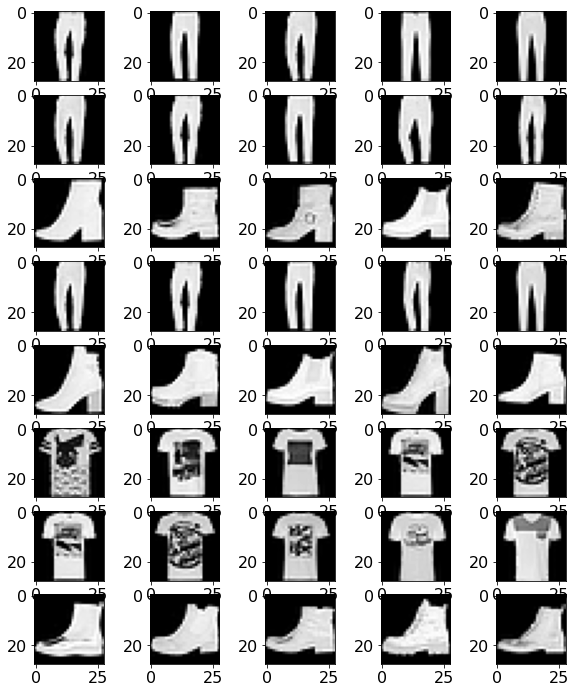

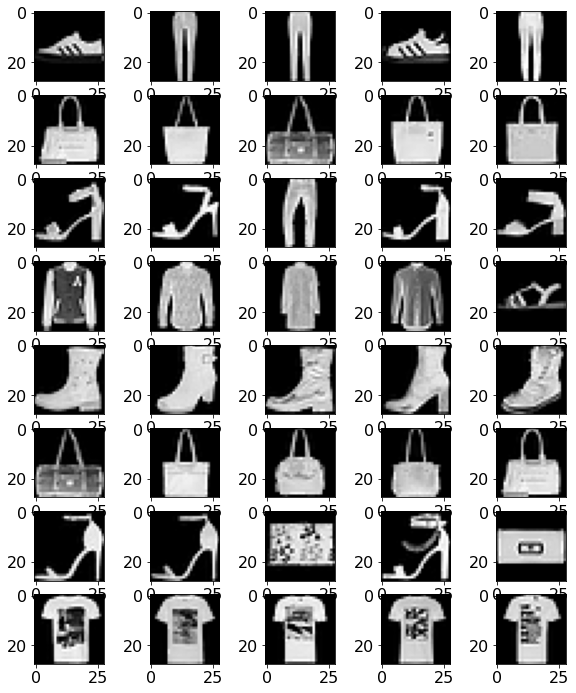

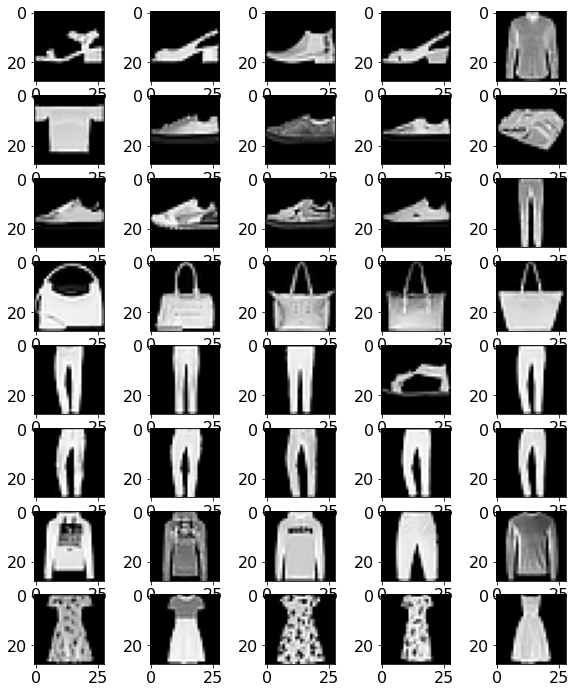

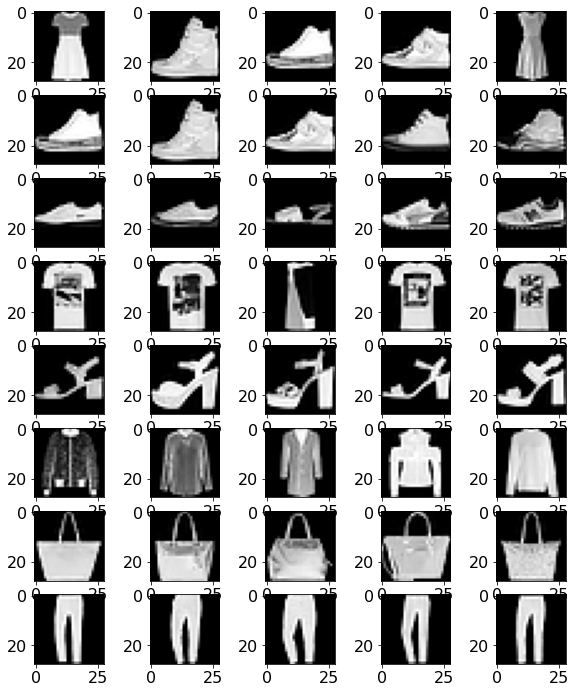

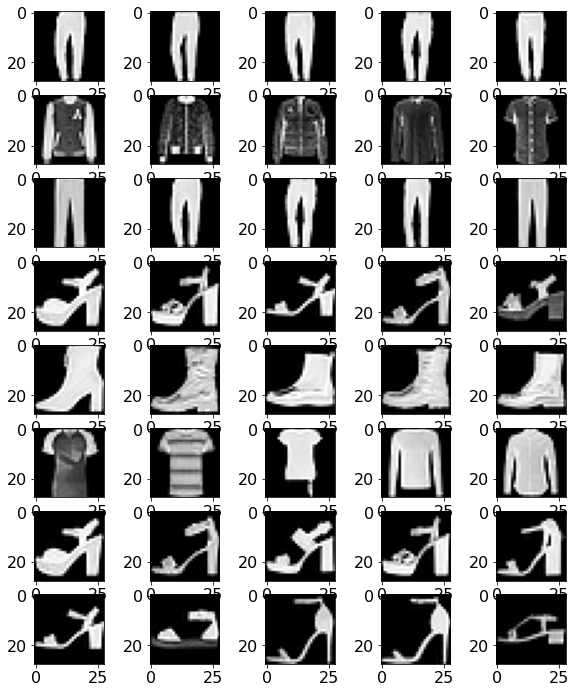

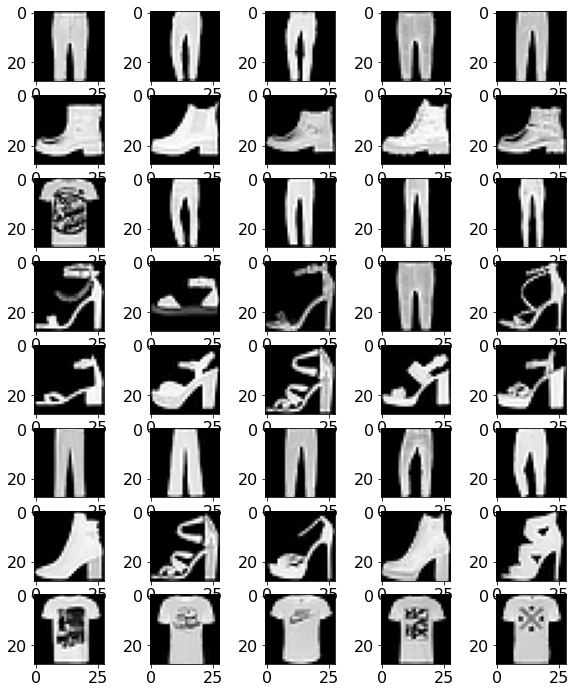

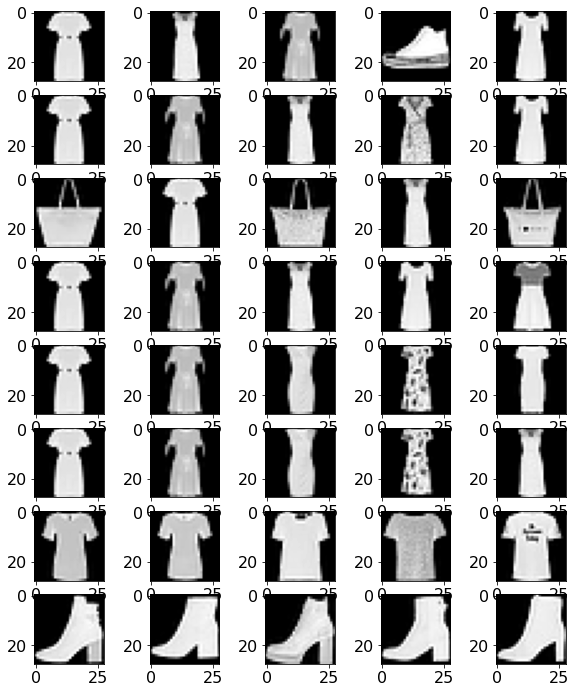

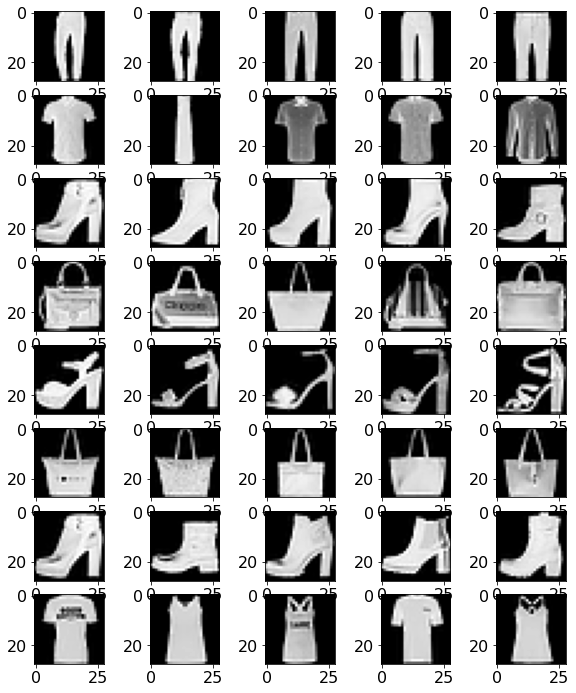

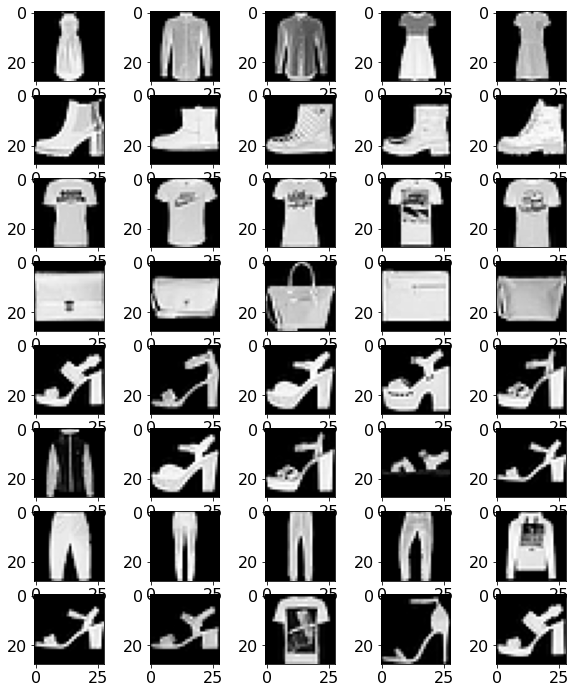

In [12]:
n_figures = 5
n_neurons = 8
folder = "../trained_models/fashion_results_h_3_corrected"

largetest = torch.utils.data.DataLoader(test, batch_size=5000, shuffle=True)
X_, Y_ = list(largetest)[0]

# Load trained models
hidden_neurons = [0, 0, 0]

def normal_forward_hook(m, i, o):
    hidden_neurons[0] = o

def horseshoe_forward_hook(m, i, o):
    hidden_neurons[1] = o

def gbfry_forward_hook(m, i, o):
    hidden_neurons[2] = o

for p in [500, 1000, 2000]:
    normal_net = torch.load('{}/normal_ffnn_{}_run_3.net'.format(folder, p)).double().to('cpu').eval()
    transform_normal(normal_net)

    horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_2.net'.format(folder, p)).double().to('cpu').eval()
    
    gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_1.net'.format(folder, p)).double().to('cpu').eval()

    normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
    horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
    gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)
    

    normal_net(X_.view(-1, 28*28))
    horseshoe_net(X_.view(-1, 28*28))
    gbfry_heavy_net(X_.view(-1, 28*28))

    # Hidden neurons
    normal_neurons = hidden_neurons[0].detach().numpy()
    horseshoe_neurons = hidden_neurons[1].detach().numpy()
    gbfry_neurons = hidden_neurons[2].detach().numpy()

    # Neurons that have the largest impact on the outcome
    normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
    gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

    # Find the most representative images for each neuron
    features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)[-n_figures:, :][::-1, :]
    features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)[-n_figures:, :][::-1, :]
    features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)[-n_figures:, :][::-1, :]
    
    # Normal
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_normal[j_-1, i_-1]])
            x.requires_grad=True
            normal_net(x.view(28*28))
            hidden_neurons[0][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_normal[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    #plt.suptitle("Gaussian prior with p={}".format(p))

    # Horseshoe
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_horseshoe[j_-1, i_-1]])
            x.requires_grad=True
            horseshoe_net(x.view(28*28))
            hidden_neurons[1][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_horseshoe[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    #plt.suptitle("Horseshoe prior with p={}".format(p))
    
    # BFRY
    plt.subplots(n_neurons, n_figures, figsize=(10, 12))
    for i_ in range(1, n_neurons+1):
        for j_ in range(1, n_figures+1):
            # Compute gradient of the image
            x = copy.deepcopy(X_[features_gbfry[j_-1, i_-1]])
            x.requires_grad=True
            gbfry_heavy_net(x.view(28*28))
            hidden_neurons[2][i_-1].backward()
            grads = x.grad.detach().abs()
            # Plot most significatif images
            plt.subplot(n_neurons, n_figures, (n_figures*(i_-1)+j_))
            plt.imshow(X_[features_gbfry[j_-1, i_-1]].detach().view(28,28), cmap="gray")
            #plt.imshow(grads.view(28,28), alpha=0.75, cmap="Reds")
    #plt.suptitle("GBFRY prior with p={}".format(p))

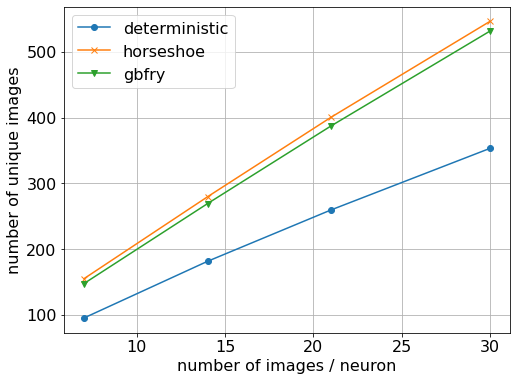

In [9]:
# Plot number of unique images for the top 30 neurons when number of representatives per neuron varies
n_neurons = 30
num_elems = [7, 14, 21, 30]


n_runs = 5

num_uniques_normal = np.zeros(len(num_elems))
num_uniques_horseshoe = np.zeros(len(num_elems))
num_uniques_gbfry = np.zeros(len(num_elems))

for p in [2000]:#[500, 1000, 2000]:
    for r in range(1, n_runs+1):
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        transform_normal(normal_net)

        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
        horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
        gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)


        normal_net(X_.view(-1, 28*28))
        horseshoe_net(X_.view(-1, 28*28))
        gbfry_heavy_net(X_.view(-1, 28*28))

        # Hidden neurons
        normal_neurons = hidden_neurons[0].detach().numpy()
        horseshoe_neurons = hidden_neurons[1].detach().numpy()
        gbfry_neurons = hidden_neurons[2].detach().numpy()

        # Neurons that have the largest impact on the outcome
        normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

        # Find the most representative images for each neuron
        features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)
        features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)
        features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)
    
        num_uniques_normal += [
            len(np.unique(features_normal[-n_f:, :])) for n_f in num_elems
        ]
        num_uniques_horseshoe += [
            len(np.unique(features_horseshoe[-n_f:, :])) for n_f in num_elems
        ]
        num_uniques_gbfry += [
            len(np.unique(features_gbfry[-n_f:, :])) for n_f in num_elems
        ]

    num_uniques_normal /= n_runs
    num_uniques_horseshoe /= n_runs
    num_uniques_gbfry /= n_runs
    
    plt.figure(figsize=(8,6))
    #plt.title(rf'$p={p}$')
    plt.xlabel('number of images / neuron')
    plt.ylabel('number of unique images')
    markers = ['o', 'x', 'v']
    
    plt.plot(
        num_elems, num_uniques_normal,            
        marker=markers[0],
        label="deterministic"
    )
    plt.plot(
        num_elems, num_uniques_horseshoe,            
        marker=markers[1],
        label="horseshoe"
    )
    plt.plot(
        num_elems, num_uniques_gbfry,            
        marker=markers[2],
        label="gbfry"
    )
    plt.legend()
    plt.grid()
    

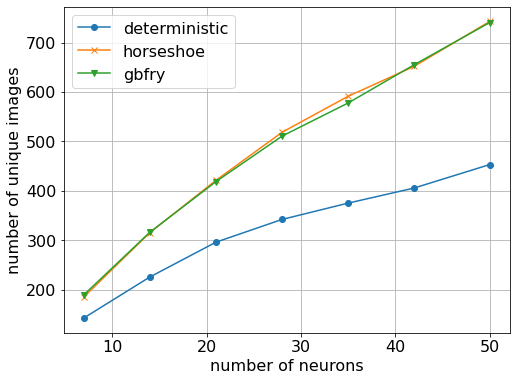

In [10]:
# Plot number of unique images  when number of representatives varies is 30 and the number of the top neurons varies
num_neurons = [7, 14, 21, 30]
num_neurons = [7, 14, 21, 28, 35, 42, 50]
n_neurons = np.max(num_neurons)

num_elems = 30

n_runs = 5

num_uniques_normal = np.zeros(len(num_neurons))
num_uniques_horseshoe = np.zeros(len(num_neurons))
num_uniques_gbfry = np.zeros(len(num_neurons))

for p in [2000]:#[500, 1000, 2000]:
    for r in range(1, n_runs+1):
        normal_net = torch.load('{}/normal_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()
        transform_normal(normal_net)

        horseshoe_net = torch.load('{}/horseshoe_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        gbfry_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu').eval()

        normal_net.hidden_layers[0].register_forward_hook(normal_forward_hook)
        horseshoe_net.hidden_layers[0].register_forward_hook(horseshoe_forward_hook)
        gbfry_heavy_net.hidden_layers[0].register_forward_hook(gbfry_forward_hook)


        normal_net(X_.view(-1, 28*28))
        horseshoe_net(X_.view(-1, 28*28))
        gbfry_heavy_net(X_.view(-1, 28*28))

        # Hidden neurons
        normal_neurons = hidden_neurons[0].detach().numpy()
        horseshoe_neurons = hidden_neurons[1].detach().numpy()
        gbfry_neurons = hidden_neurons[2].detach().numpy()

        # Neurons that have the largest impact on the outcome
        normal_idx = np.argsort(normal_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        horseshoe_idx = np.argsort(horseshoe_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]
        gbfry_heavy_idx = np.argsort(gbfry_heavy_net.hidden_layers[1].get_variances().detach().numpy().flatten())[-n_neurons:][::-1]

        # Find the most representative images for each neuron
        features_normal = np.argsort(normal_neurons[:, normal_idx], axis=0)
        features_horseshoe = np.argsort(horseshoe_neurons[:, horseshoe_idx], axis=0)
        features_gbfry = np.argsort(gbfry_neurons[:, gbfry_heavy_idx], axis=0)
    
        num_uniques_normal += [
            len(np.unique(features_normal[-num_elems:, :n_n])) for n_n in num_neurons
        ]
        num_uniques_horseshoe += [
            len(np.unique(features_horseshoe[-num_elems:, :n_n])) for n_n in num_neurons
        ]
        num_uniques_gbfry += [
            len(np.unique(features_gbfry[-num_elems:, :n_n])) for n_n in num_neurons
        ]
    
    num_uniques_normal /= n_runs
    num_uniques_horseshoe /= n_runs
    num_uniques_gbfry /= n_runs
    
    plt.figure(figsize=(8,6))
    #plt.title(rf'$p={p}$')
    plt.xlabel('number of neurons')
    plt.ylabel('number of unique images')
    markers = ['o', 'x', 'v']
    
    plt.plot(
        num_neurons, num_uniques_normal,            
        marker=markers[0],
        label="deterministic"
    )
    plt.plot(
        num_neurons, num_uniques_horseshoe,            
        marker=markers[1],
        label="horseshoe"
    )
    plt.plot(
        num_neurons, num_uniques_gbfry,            
        marker=markers[2],
        label="gbfry"
    )
    plt.legend()
    plt.grid()
    

# WIP

In [3]:
q_list = [.5, .8, .9, .95, .98, .985, .99]
folder = "../trained_models/results_h_3_corrected"
folder = "../trained_models/fashion_results_ggp"
n_runs = 5

results_ggp = {}

for p in [2000]:#[500, 1000, 2000]:
    n_acc = []
    h_acc = []
    g_acc = []
    gl_acc = []
    gm_acc = []
    trunc_list = []
    
    for r in range(1, n_runs+1):
        #ggp_heavy_net = torch.load('{}/gbfry_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        ggp_light_net = torch.load('{}/ggp_light_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        
        ggp_mid_net = torch.load('{}/ggp_vheavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')
        ggp_heavy_net = torch.load('{}/ggp_heavy_ffnn_{}_run_{}.net'.format(folder, p, r)).double().to('cpu')

        for q in tqdm(q_list):
            truncate_quantile(ggp_heavy_net, q)
            truncate_quantile(ggp_light_net, q)
            truncate_quantile(ggp_mid_net, q)

            g_acc.append(compute_accuracy(ggp_heavy_net))
            gl_acc.append(compute_accuracy(ggp_light_net))
            gm_acc.append(compute_accuracy(ggp_mid_net))
            trunc_list.append(q*100)
        
       
    results_ggp[p] = pd.DataFrame.from_dict({
        "truncation": trunc_list,
        'ggp_heavy': g_acc,
        'ggp_light': gl_acc,
        'ggp_vheavy': gm_acc,
    })

    print("Results with p = {}".format(p))
    print(results_ggp[p].groupby('truncation').mean())
    print(results_ggp[p].groupby('truncation').std())


100%|██████████| 7/7 [01:52<00:00, 16.05s/it]

Results with p = 2000
            ggp_heavy  ggp_light  ggp_vheavy
truncation                                  
50.0            88.34      88.52       88.50
80.0            88.34      88.52       88.50
90.0            88.36      88.52       88.50
95.0            88.18      88.02       88.22
98.0            79.14      72.18       77.88
98.5            61.78      56.56       61.98
99.0            34.52      34.58       38.88
            ggp_heavy  ggp_light  ggp_vheavy
truncation                                  
50.0         0.194936   0.083666    0.273861
80.0         0.194936   0.083666    0.273861
90.0         0.207364   0.148324    0.300000
95.0         0.327109   0.192354    0.432435
98.0         4.290455  10.607874    5.818677
98.5         8.802102  14.593937    7.919722
99.0        12.355039  11.710551    8.062692
